room type
Entire home/apt    51645
Private room       44955
Shared room         2158
Hotel room           115
Name: count, dtype: int64


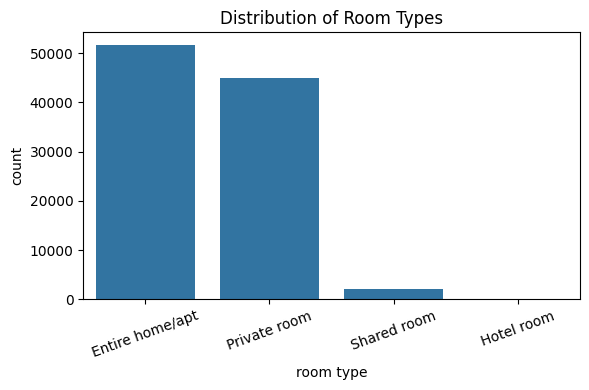

neighbourhood group
Manhattan        41995
Brooklyn         40317
Queens           12947
Bronx             2657
Staten Island      929
nan                 28
Name: count, dtype: int64


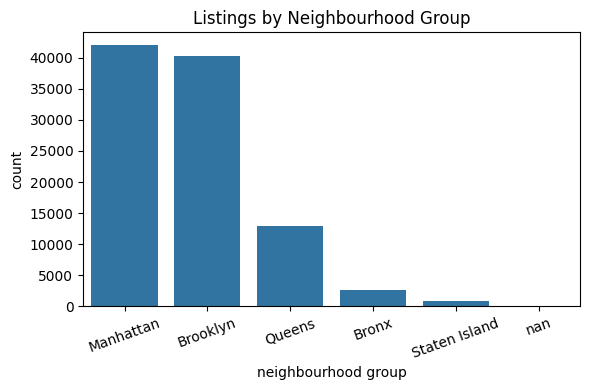

neighbourhood group
nan              644.962963
Queens           629.859687
Bronx            628.270943
Brooklyn         626.726061
Staten Island    624.930886
Manhattan        623.492851
Name: price, dtype: float64


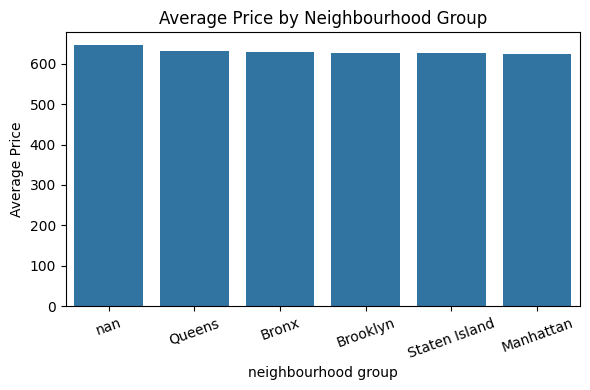

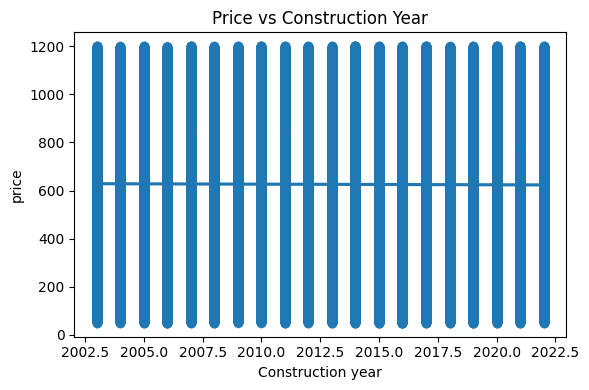

host id      host name 
69623510966  Blueground    332.0
61907398658  Blueground    332.0
61667701835  Blueground    332.0
52760110374  Blueground    332.0
59913507223  Blueground    332.0
18344435096  Blueground    332.0
90148229302  Blueground    332.0
87944211655  Blueground    332.0
87920381104  Blueground    332.0
80832323346  Blueground    332.0
Name: calculated host listings count, dtype: float64
is_verified
False    3.282535
True     3.292365
Name: review rate number, dtype: float64


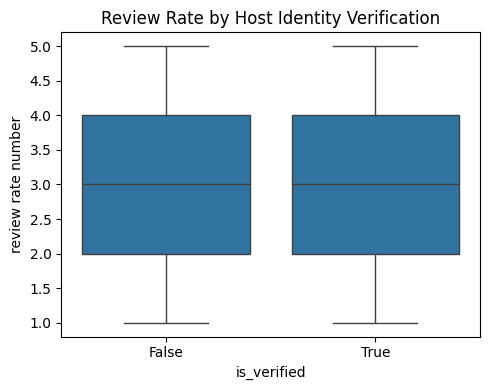

0.9999908730092819


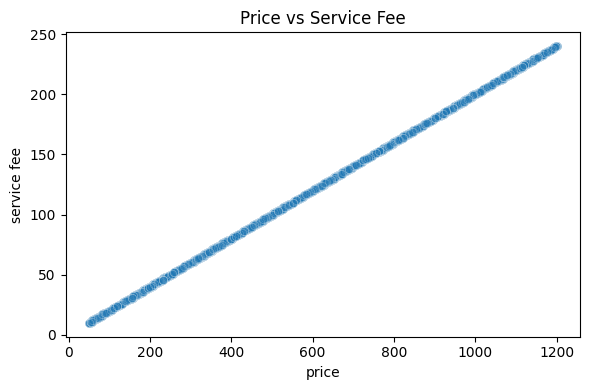

neighbourhood group  room type      
Brooklyn             Hotel room         3.857143
Queens               Hotel room         3.750000
Staten Island        Shared room        3.533333
Manhattan            Hotel room         3.500000
Staten Island        Private room       3.467562
Queens               Shared room        3.368571
                     Entire home/apt    3.357357
Bronx                Private room       3.342295
                     Entire home/apt    3.342000
Brooklyn             Shared room        3.334975
Staten Island        Entire home/apt    3.329004
Queens               Private room       3.322859
Manhattan            Private room       3.286957
                     Entire home/apt    3.283515
Brooklyn             Private room       3.272713
Manhattan            Shared room        3.272410
Bronx                Shared room        3.260870
Brooklyn             Entire home/apt    3.259531
nan                  Entire home/apt    3.222222
                     Private roo

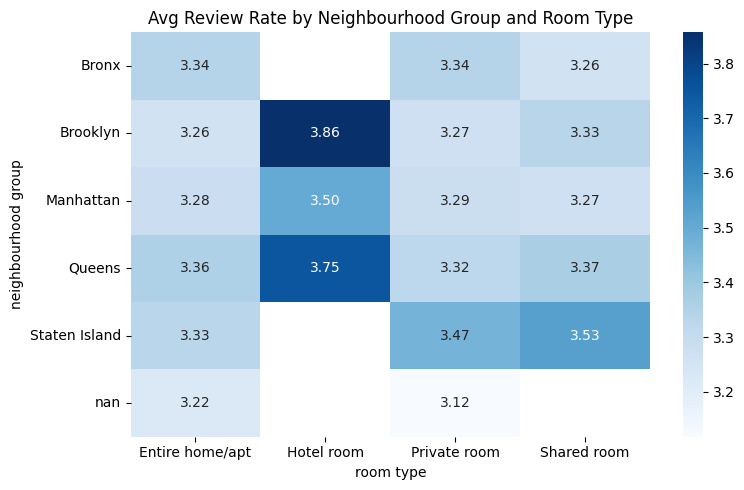

0.1746285378999848


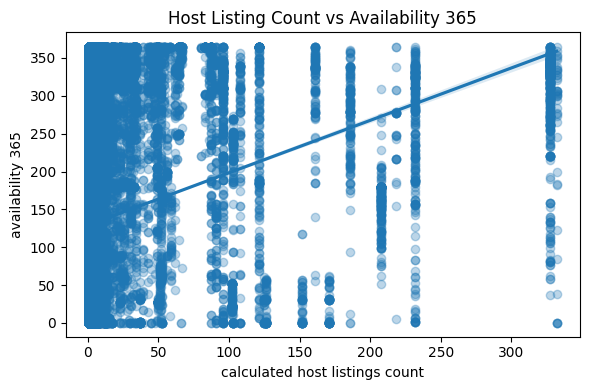

Combined cleaning + analysis complete


In [2]:
# Combined notebook cell: data loading, cleaning, and analysis visualizations
# This cell loads the Excel, cleans key fields, applies sensible NA handling, fixes spellings, removes extreme availability outliers,
# and then produces the same analyses and charts as before.

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 1) Load
df_all = pd.read_excel('1730285881-Airbnb_Open_Data (1).xlsx', sheet_name='in')
df_all.columns = [c.strip() for c in df_all.columns]

# 2) Basic cleaning
if 'price' in df_all.columns:
    df_all['price'] = pd.to_numeric(df_all['price'].astype(str).str.replace('$','', regex=False).str.replace(',','', regex=False), errors='coerce')
if 'service fee' in df_all.columns:
    df_all['service fee'] = pd.to_numeric(df_all['service fee'].astype(str).str.replace('$','', regex=False).str.replace(',','', regex=False), errors='coerce')

# Parse dates (ms epoch or iso)
if 'last review' in df_all.columns:
    lr_ms = pd.to_datetime(df_all['last review'], errors='coerce', unit='ms')
    lr_std = pd.to_datetime(df_all['last review'], errors='coerce')
    df_all['last review'] = lr_ms.fillna(lr_std)

# Normalize booleans/text
if 'instant_bookable' in df_all.columns:
    df_all['instant_bookable'] = df_all['instant_bookable'].astype(str).str.lower().map({'true': True, 'false': False})

# Type coercions
num_cols = ['lat','long','Construction year','minimum nights','number of reviews','reviews per month','review rate number','calculated host listings count','availability 365']
for c in num_cols:
    if c in df_all.columns:
        df_all[c] = pd.to_numeric(df_all[c], errors='coerce')

# Fix neighborhood spelling variants
if 'neighbourhood group' in df_all.columns:
    df_all['neighbourhood group'] = df_all['neighbourhood group'].astype(str).replace({'brooklin':'Brooklyn','BROOKLIN':'Brooklyn','brooklyn':'Brooklyn','manhatan':'Manhattan','brookln':'Brooklyn'})

# 3) Drop duplicate rows by id if present
if 'id' in df_all.columns:
    df_all = df_all.drop_duplicates(subset=['id'])
else:
    df_all = df_all.drop_duplicates()

# 4) Remove outliers in availability 365 using reasonable bounds [0, 365]
if 'availability 365' in df_all.columns:
    df_all = df_all[(df_all['availability 365'] >= 0) & (df_all['availability 365'] <= 365) | df_all['availability 365'].isna()]

# 5) Create a working copy for analysis without overly strict NA dropping
df_vis = df_all.copy()

# ANALYSES
# A) Room type distribution
rt_counts = df_vis['room type'].dropna().value_counts()
print(rt_counts.head(10))
plt.figure(figsize=(6,4))
sns.countplot(data=df_vis, x='room type', order=df_vis['room type'].value_counts().index)
plt.xticks(rotation=20)
plt.title('Distribution of Room Types')
plt.tight_layout()
plt.show()

# B) Listings by neighbourhood group
ng_counts = df_vis['neighbourhood group'].dropna().value_counts()
print(ng_counts.head(10))
plt.figure(figsize=(6,4))
sns.countplot(data=df_vis, x='neighbourhood group', order=df_vis['neighbourhood group'].value_counts().index)
plt.xticks(rotation=20)
plt.title('Listings by Neighbourhood Group')
plt.tight_layout()
plt.show()

# C) Average price by neighbourhood group
ng_price = df_vis.dropna(subset=['price']).groupby('neighbourhood group')['price'].mean().sort_values(ascending=False)
print(ng_price.head(10))
plt.figure(figsize=(6,4))
sns.barplot(x=ng_price.index, y=ng_price.values)
plt.xticks(rotation=20)
plt.ylabel('Average Price')
plt.title('Average Price by Neighbourhood Group')
plt.tight_layout()
plt.show()

# D) Price vs Construction year
scat_df = df_vis.dropna(subset=['Construction year','price'])
plt.figure(figsize=(6,4))
sns.regplot(data=scat_df, x='Construction year', y='price', scatter_kws={'alpha':0.3})
plt.title('Price vs Construction Year')
plt.tight_layout()
plt.show()

# E) Top hosts by listing count (max observed per host)
if 'calculated host listings count' in df_vis.columns and 'host id' in df_vis.columns and 'host name' in df_vis.columns:
    top_hosts = df_vis.groupby(['host id','host name'], dropna=False)['calculated host listings count'].max().sort_values(ascending=False).head(10)
    print(top_hosts)

# F) Review rate vs host verification
if 'host_identity_verified' in df_vis.columns and 'review rate number' in df_vis.columns:
    ver = df_vis.dropna(subset=['host_identity_verified','review rate number']).copy()
    ver['is_verified'] = ver['host_identity_verified'].astype(str).str.lower().eq('verified')
    print(ver.groupby('is_verified')['review rate number'].mean())
    plt.figure(figsize=(5,4))
    sns.boxplot(data=ver, x='is_verified', y='review rate number')
    plt.title('Review Rate by Host Identity Verification')
    plt.tight_layout()
    plt.show()

# G) Correlation: price vs service fee
if 'price' in df_vis.columns and 'service fee' in df_vis.columns:
    pf = df_vis[['price','service fee']].dropna()
    if not pf.empty:
        print(pf['price'].corr(pf['service fee']))
        plt.figure(figsize=(6,4))
        sns.scatterplot(data=pf, x='price', y='service fee', alpha=0.3)
        plt.title('Price vs Service Fee')
        plt.tight_layout()
        plt.show()

# H) Avg review rate by neighborhood group and room type
if 'review rate number' in df_vis.columns and 'neighbourhood group' in df_vis.columns and 'room type' in df_vis.columns:
    grp_rate = df_vis.dropna(subset=['review rate number']).groupby(['neighbourhood group','room type'])['review rate number'].mean().sort_values(ascending=False)
    print(grp_rate.head(20))
    pivot_rate = df_vis.pivot_table(index='neighbourhood group', columns='room type', values='review rate number', aggfunc='mean')
    plt.figure(figsize=(8,5))
    sns.heatmap(pivot_rate, annot=True, fmt='.2f', cmap='Blues')
    plt.title('Avg Review Rate by Neighbourhood Group and Room Type')
    plt.tight_layout()
    plt.show()

# I) Host listing count vs availability
if 'calculated host listings count' in df_vis.columns and 'availability 365' in df_vis.columns:
    ha = df_vis[['calculated host listings count','availability 365']].dropna()
    if not ha.empty:
        print(ha['calculated host listings count'].corr(ha['availability 365']))
        plt.figure(figsize=(6,4))
        sns.regplot(data=ha, x='calculated host listings count', y='availability 365', scatter_kws={'alpha':0.3})
        plt.title('Host Listing Count vs Availability 365')
        plt.tight_layout()
        plt.show()

print('Combined cleaning + analysis complete')